# Era-5 precipitation super res
In this notebook I experiment with statistical downscaling via super resolution on the era5 dataset. In this implementation I utilize a fairly small dataset of era5 monthly averaged total precipitation data running from 1959 to 2022 regarding continental europe. 

The implemented network is ESPCN (Efficient Sub-Pixel CNN), proposed by [Shi, 2016](https://arxiv.org/abs/1609.05158)

## Setup

In [22]:
import tensorflow as tf

import os
import math
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory

from IPython.display import display

In [23]:
# copy zipped dataset in folder
!unzip /content/monthly_precipitation_dataset.zip

Archive:  /content/monthly_precipitation_dataset.zip
replace monthly_precipitation_dataset/100.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [24]:
#set root dir
root_dir = "/content/monthly_precipitation_dataset"

We create training and validation datasets via `image_dataset_from_directory`.

In [25]:
crop_size = 240
upscale_factor = 3
input_size = crop_size // upscale_factor
batch_size = 8

train_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="training",
    seed=1337,
    label_mode=None,
)

valid_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="validation",
    seed=1337,
    label_mode=None,
)

Found 768 files belonging to 1 classes.
Using 615 files for training.
Found 768 files belonging to 1 classes.
Using 153 files for validation.


We rescale the images to take values in the range [0, 1].

In [26]:

def scaling(input_image):
    input_image = input_image / 255.0
    return input_image


# Scale from (0, 255) to (0, 1)
train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)

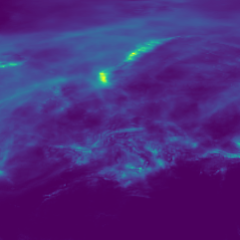

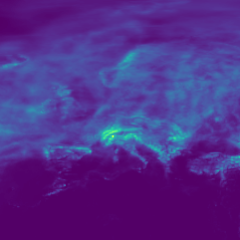

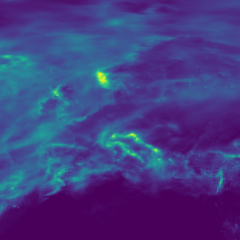

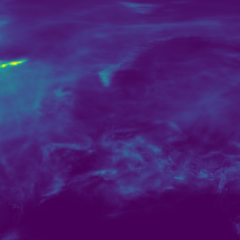

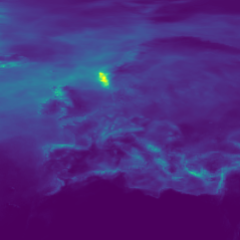

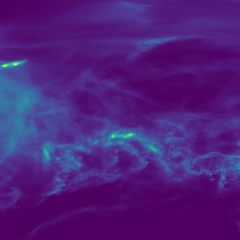

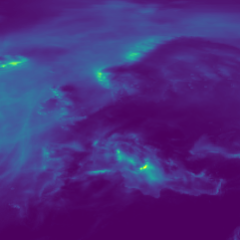

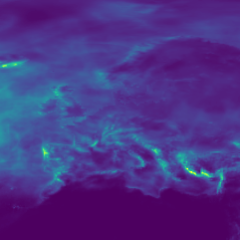

In [28]:
for batch in train_ds.take(1):
    for img in batch:
        display(array_to_img(img))

We prepare a dataset of test image paths that we will use for
visual evaluation at the end of this example.

In [29]:
dataset = os.path.join(root_dir, "images")
test_path = os.path.join(dataset, "test")

test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir(test_path)
        if fname.endswith(".png")
    ]
)

## Crop and resize images



In [32]:

# Use TF Ops to process.
def process_input(input, input_size, upscale_factor):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method="area")


def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y


train_ds = train_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = valid_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
valid_ds = valid_ds.prefetch(buffer_size=32)

Let's take a look at the input and target data.

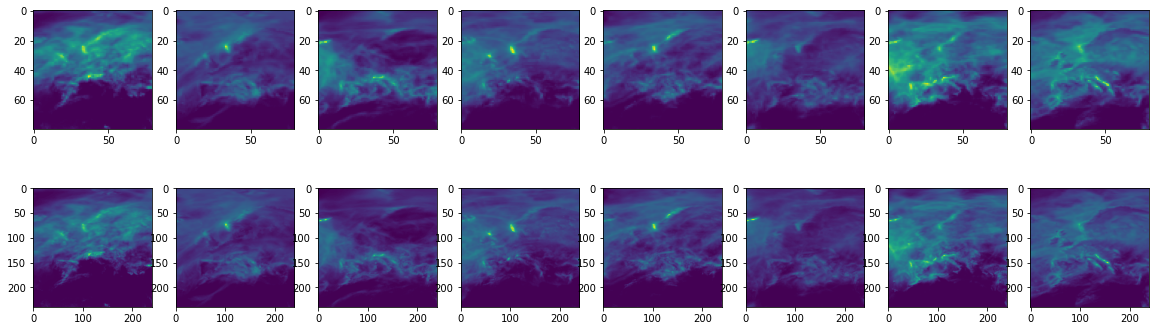

In [45]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,8,figsize=(20,6))

i = 0
j = 0

for batch in train_ds.take(1):
  for im in batch[0]:
    axs[0,i].imshow(im) 
    i = i+1
  i = 0
  for im in batch[1]:
    axs[1,i].imshow(im)
    i = i+1

## Build a sequential model model with depth to space.

In [47]:

def get_model(upscale_factor=3, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, padding="same", activation="sigmoid")(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return keras.Model(inputs, outputs)


## Define utility functions

We need to define several utility functions to monitor our results:

- `plot_results` to plot an save an image.
- `get_lowres_image` to convert an image to its low-resolution version.
- `upscale_image` to turn a low-resolution image to
a high-resolution version reconstructed by the model.
In this function, we use the `y` channel from the YUV color space
as input to the model and then combine the output with the
other channels to obtain an RGB image.

In [54]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL


def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots(figsize=(7, 7))
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 1.8, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 60, 120, 60, 120
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()


def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img


## Define callbacks to monitor training

The `ESPCNCallback` object will compute and display
the [PSNR](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio) metric.
This is the main metric we use to evaluate super-resolution performance.

In [49]:
class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.test_img = get_lowres_image(load_img(test_img_paths[0]), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))


Define `ModelCheckpoint` and `EarlyStopping` callbacks.

In [50]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "/tmp/checkpoint"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.0001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 64)    1664      
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 32)    18464     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 9)     2601      
                                                                 
 tf.nn.depth_to_space (TFOpL  (None, None, None, 1)    0         
 ambda)                                                          
                                                             

## Train the model

Epoch 1/100
Mean PSNR for epoch: 16.75
1/1 [==============================] - 0s 133ms/step


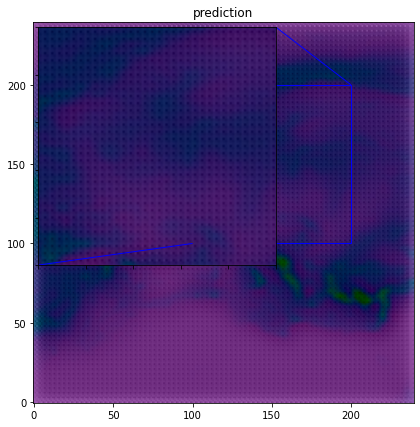

77/77 - 14s - loss: 0.0506 - val_loss: 0.0221 - 14s/epoch - 182ms/step
Epoch 2/100
Mean PSNR for epoch: 17.83
77/77 - 4s - loss: 0.0198 - val_loss: 0.0165 - 4s/epoch - 46ms/step
Epoch 3/100
Mean PSNR for epoch: 24.79
77/77 - 3s - loss: 0.0102 - val_loss: 0.0034 - 3s/epoch - 34ms/step
Epoch 4/100
Mean PSNR for epoch: 29.98
77/77 - 3s - loss: 0.0018 - val_loss: 0.0010 - 3s/epoch - 34ms/step
Epoch 5/100
Mean PSNR for epoch: 31.56
77/77 - 2s - loss: 8.5944e-04 - val_loss: 7.1639e-04 - 2s/epoch - 32ms/step
Epoch 6/100
Mean PSNR for epoch: 32.31
77/77 - 2s - loss: 6.6321e-04 - val_loss: 5.8422e-04 - 2s/epoch - 31ms/step
Epoch 7/100
Mean PSNR for epoch: 33.35
77/77 - 2s - loss: 5.3511e-04 - val_loss: 4.6221e-04 - 2s/epoch - 32ms/step
Epoch 8/100
Mean PSNR for epoch: 34.29
77/77 - 5s - loss: 4.3423e-04 - val_loss: 3.8040e-04 - 5s/epoch - 60ms/step
Epoch 9/100
Mean PSNR for epoch: 34.83
77/77 - 2s - loss: 3.6621e-04 - val_loss: 3.2677e-04 - 2s/epoch - 32ms/step
Epoch 10/100
Mean PSNR for epoch:

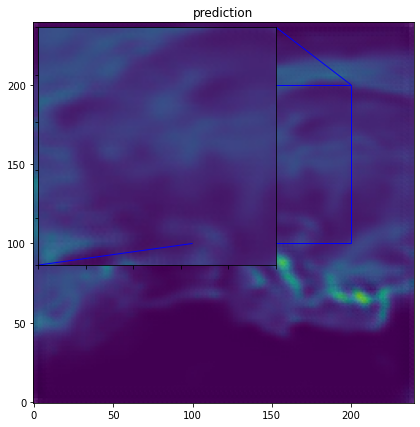

77/77 - 3s - loss: 1.4101e-04 - val_loss: 1.2993e-04 - 3s/epoch - 38ms/step
Epoch 22/100
Mean PSNR for epoch: 39.14
77/77 - 3s - loss: 1.3487e-04 - val_loss: 1.2471e-04 - 3s/epoch - 45ms/step
Epoch 23/100
Mean PSNR for epoch: 39.19
77/77 - 3s - loss: 1.3009e-04 - val_loss: 1.2043e-04 - 3s/epoch - 33ms/step
Epoch 24/100
Mean PSNR for epoch: 39.44
77/77 - 2s - loss: 1.2500e-04 - val_loss: 1.1557e-04 - 2s/epoch - 30ms/step
Epoch 25/100
Mean PSNR for epoch: 39.46
77/77 - 3s - loss: 1.2068e-04 - val_loss: 1.1268e-04 - 3s/epoch - 34ms/step
Epoch 26/100
Mean PSNR for epoch: 39.72
77/77 - 3s - loss: 1.1713e-04 - val_loss: 1.0851e-04 - 3s/epoch - 42ms/step
Epoch 27/100
Mean PSNR for epoch: 39.70
77/77 - 3s - loss: 1.1322e-04 - val_loss: 1.0456e-04 - 3s/epoch - 33ms/step
Epoch 28/100
Mean PSNR for epoch: 40.02
77/77 - 2s - loss: 1.0979e-04 - val_loss: 1.0166e-04 - 2s/epoch - 31ms/step
Epoch 29/100
Mean PSNR for epoch: 39.99
77/77 - 3s - loss: 1.0684e-04 - val_loss: 9.8525e-05 - 3s/epoch - 44ms/s

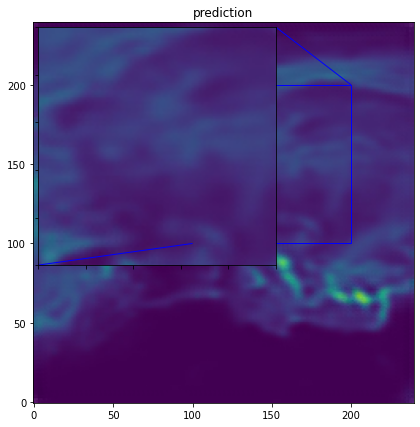

77/77 - 3s - loss: 8.1431e-05 - val_loss: 7.5238e-05 - 3s/epoch - 41ms/step
Epoch 42/100
Mean PSNR for epoch: 41.26
77/77 - 3s - loss: 7.9861e-05 - val_loss: 7.4983e-05 - 3s/epoch - 44ms/step
Epoch 43/100
Mean PSNR for epoch: 41.43
77/77 - 3s - loss: 7.8963e-05 - val_loss: 7.3074e-05 - 3s/epoch - 33ms/step
Epoch 44/100
Mean PSNR for epoch: 41.10
77/77 - 2s - loss: 7.8004e-05 - val_loss: 7.6857e-05 - 2s/epoch - 31ms/step
Epoch 45/100
Mean PSNR for epoch: 41.44
77/77 - 4s - loss: 7.8920e-05 - val_loss: 7.1853e-05 - 4s/epoch - 47ms/step
Epoch 46/100
Mean PSNR for epoch: 41.66
77/77 - 3s - loss: 7.5254e-05 - val_loss: 7.0615e-05 - 3s/epoch - 33ms/step
Epoch 47/100
Mean PSNR for epoch: 41.68
77/77 - 2s - loss: 7.4336e-05 - val_loss: 6.8735e-05 - 2s/epoch - 30ms/step
Epoch 48/100
Mean PSNR for epoch: 41.74
77/77 - 3s - loss: 7.3074e-05 - val_loss: 6.7719e-05 - 3s/epoch - 33ms/step
Epoch 49/100
Mean PSNR for epoch: 41.68
77/77 - 3s - loss: 7.2567e-05 - val_loss: 6.7817e-05 - 3s/epoch - 43ms/s

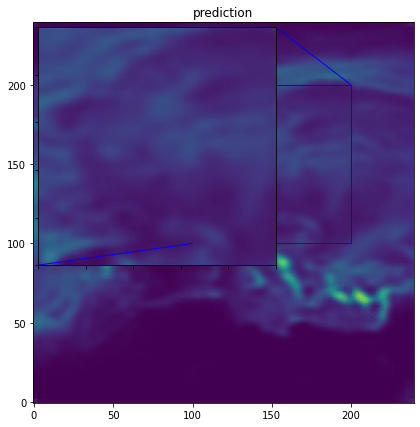

77/77 - 3s - loss: 6.6845e-05 - val_loss: 5.8714e-05 - 3s/epoch - 37ms/step
Epoch 62/100
Mean PSNR for epoch: 42.42
77/77 - 3s - loss: 6.2698e-05 - val_loss: 5.8202e-05 - 3s/epoch - 45ms/step
Epoch 63/100
Mean PSNR for epoch: 42.56
77/77 - 2s - loss: 6.2219e-05 - val_loss: 5.7672e-05 - 2s/epoch - 32ms/step
Epoch 64/100
Mean PSNR for epoch: 42.40
77/77 - 3s - loss: 6.1964e-05 - val_loss: 5.7338e-05 - 3s/epoch - 33ms/step
Epoch 65/100
Mean PSNR for epoch: 42.53
77/77 - 4s - loss: 6.1557e-05 - val_loss: 5.8048e-05 - 4s/epoch - 47ms/step
Epoch 66/100
Mean PSNR for epoch: 42.63
77/77 - 2s - loss: 7.2213e-05 - val_loss: 5.6855e-05 - 2s/epoch - 30ms/step
Epoch 67/100
Mean PSNR for epoch: 42.63
77/77 - 3s - loss: 6.0237e-05 - val_loss: 5.5912e-05 - 3s/epoch - 33ms/step
Epoch 68/100
Mean PSNR for epoch: 42.61
77/77 - 2s - loss: 5.9753e-05 - val_loss: 5.5499e-05 - 2s/epoch - 31ms/step
Epoch 69/100
Mean PSNR for epoch: 42.74
77/77 - 3s - loss: 5.9357e-05 - val_loss: 5.5100e-05 - 3s/epoch - 44ms/s

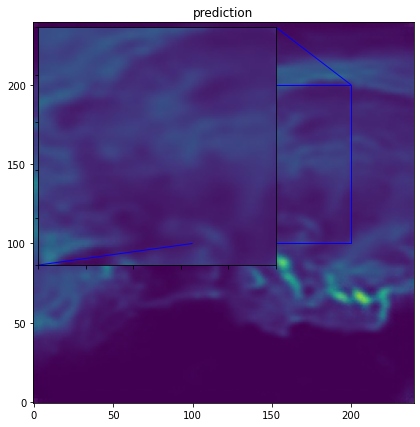

77/77 - 3s - loss: 5.4753e-05 - val_loss: 5.0800e-05 - 3s/epoch - 41ms/step
Epoch 82/100
Mean PSNR for epoch: 43.03
77/77 - 3s - loss: 5.4494e-05 - val_loss: 5.0527e-05 - 3s/epoch - 34ms/step
Epoch 83/100
Mean PSNR for epoch: 43.08
77/77 - 3s - loss: 5.4204e-05 - val_loss: 5.0254e-05 - 3s/epoch - 45ms/step
Epoch 84/100
Mean PSNR for epoch: 43.13
77/77 - 3s - loss: 5.3910e-05 - val_loss: 5.0033e-05 - 3s/epoch - 33ms/step
Epoch 85/100
Mean PSNR for epoch: 43.19
77/77 - 2s - loss: 5.3633e-05 - val_loss: 4.9688e-05 - 2s/epoch - 31ms/step
Epoch 86/100
Mean PSNR for epoch: 43.15
77/77 - 2s - loss: 5.3400e-05 - val_loss: 4.9545e-05 - 2s/epoch - 31ms/step
Epoch 87/100
Mean PSNR for epoch: 43.22
77/77 - 3s - loss: 5.3141e-05 - val_loss: 4.9131e-05 - 3s/epoch - 45ms/step
Epoch 88/100
Mean PSNR for epoch: 43.10
77/77 - 2s - loss: 5.2778e-05 - val_loss: 4.9474e-05 - 2s/epoch - 31ms/step
Epoch 89/100
Mean PSNR for epoch: 43.28
77/77 - 2s - loss: 5.2595e-05 - val_loss: 4.8565e-05 - 2s/epoch - 30ms/s

In [51]:
epochs = 100

model.compile(
    optimizer=optimizer, loss=loss_fn,
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=2
)

# The model weights (that are considered the best) are loaded into the model.
#model.load_weights(checkpoint_filepath)

## plot the results


1/1 [==============================] - 0s 42ms/step
PSNR of low resolution image and high resolution image is 39.8395
PSNR of predict and high resolution is 37.7936


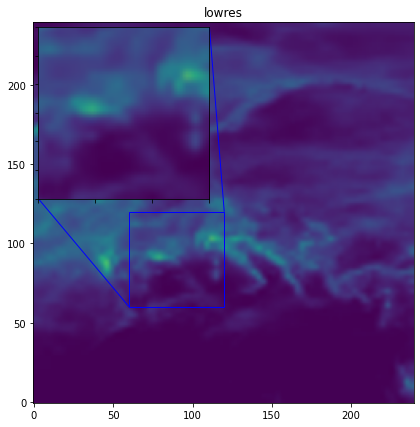

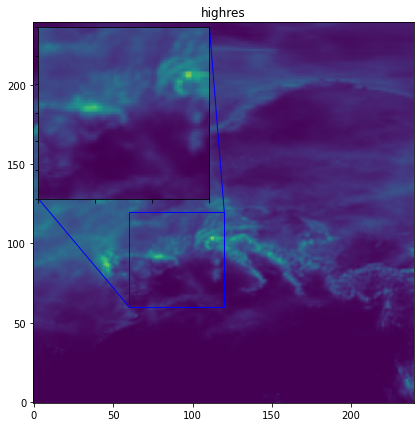

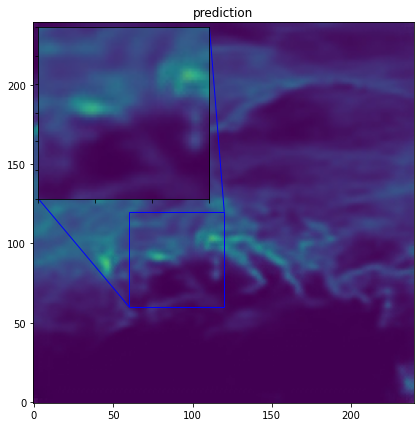

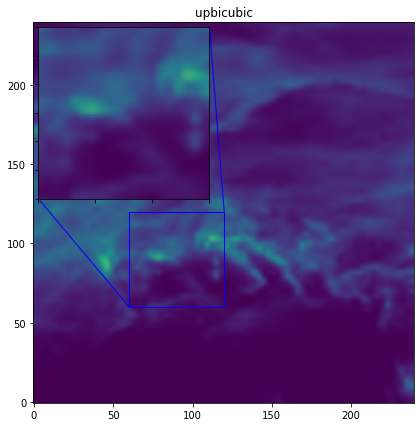

In [69]:

total_bicubic_psnr = 0.0
total_test_psnr = 0.0
index = 0 
test_img_path = test_img_paths[20]

img = load_img(test_img_path)
lowres_input = get_lowres_image(img, upscale_factor)
w = lowres_input.size[0] * upscale_factor
h = lowres_input.size[1] * upscale_factor
highres_img = img.resize((w, h))
prediction = upscale_image(model, lowres_input)
lowres_img = lowres_input.resize((w, h))
lowres_img_arr = img_to_array(lowres_img)
highres_img_arr = img_to_array(highres_img)
predict_img_arr = img_to_array(prediction)
bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)

total_bicubic_psnr += bicubic_psnr
total_test_psnr += test_psnr

print(
    "PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr
)
print("PSNR of predict and high resolution is %.4f" % test_psnr)
plot_results(lowres_img, index, "lowres")
plot_results(highres_img, index, "highres")
plot_results(prediction, index, "prediction")

upcubic = lowres_input.resize((lowres_input.size[0] * upscale_factor, lowres_input.size[1] * upscale_factor),PIL.Image.BICUBIC,)
plot_results(upcubic, index, "upbicubic")




## compute some metrics

In [70]:
import cv2
psnr_pred = cv2.PSNR(np.array(highres_img), np.array(prediction))
psnr_bicubic = cv2.PSNR(np.array(highres_img), np.array(upcubic))
print("psnr for preditction->", psnr_pred)
print("psnr for bicubic->",psnr_bicubic)

psnr for preditction-> 37.79356977061858
psnr for bicubic-> 39.83953856869394


In [71]:
mse_pred = np.square(np.subtract(highres_img,prediction)).mean()
mse_bicubic = np.square(np.subtract(highres_img,upcubic)).mean()
print("mse for preditction->", mse_pred)
print("mse for bicubic->",mse_bicubic)

mse for preditction-> 9.029675925925925
mse for bicubic-> 4.9872453703703705
